#  Clusterización del dataset Iris con K-Means

Vamos a aplicar el método de K-Means sobre el dataset Iris. Este dataset cuenta con etiquetas de clase, con lo que sería más apropiado aplicar un método de clasificación supervisada. Sin embargo, vamos a ignorar las etiquetas de clase y vamos a aplicar K-Means a modo de clustering, comparando *a posteriori* los resultados obtenidos con las etiquetas reales.

In [81]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()

print(iris.feature_names)
print(iris.data[:5])
print(iris.target_names)
print(iris.target[:5])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0]


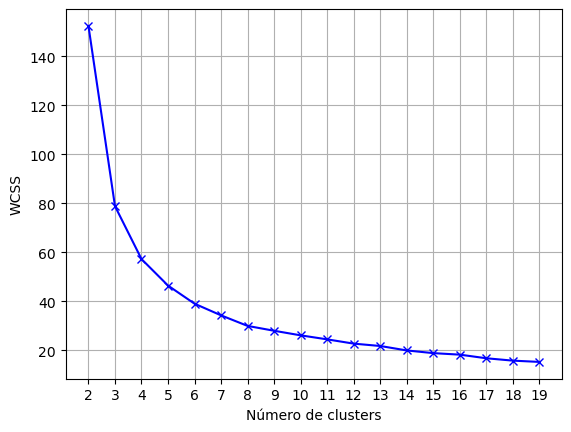

In [82]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inercia = []
K = range(2,20)
for n_clusters in K:
    model = KMeans(n_clusters, n_init = 20).fit(iris.data)
    inercia.append(model.inertia_)
    
plt.plot(K, inercia, 'bx-')
plt.xticks(K)
plt.grid(True)
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.show()

Con los valores por defecto n_init='auto' y init='k-means++', [el número de iteraciones es 1](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). Se puede observar que no fijando la semilla, la representación en este caso varía mucho. Eso es debido a que el algoritmo de K-Means es sensible a la inicialización de los centroides y no está consiguiendo converger a un mínimo global en algunos casos. Incrementando el número de iteraciones, se puede observar que la representación es más estable, por eso se ha fijado n_init=100.

Un vez el gráfico es estable, sí se puede apreciar el cambio de pendiente en 3 (aunque también podría considerarse en 5 o en torno a 10, lo que muestra lo subjetivo de la elección del número de clusters por este método).

## Comparación de los resultados obtenidos con las etiquetas reales

Defino una función que representa con marcadores diferentes cada clase real y con colores cada cluster obtenido en función de un valor de k que recibe como parámetro. Dado que existen 4 dimensiones, se representan que sabemos que más correlan con la clase real, según nos indica la documentación (en iris.DESCR):

```
============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================
```

In [83]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_compare_iris_n_clusters(n_clusters):
    y = KMeans(n_clusters, n_init = 20).fit_predict(iris.data) # Entrenamos el modelo y predecimos los clusters
    
    iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names) # Creamos un DataFrame con los datos para usarlo en Seaborn
    iris_df['species'] = iris.target_names[iris.target] # Añadimos la especie de cada flor con su nombre
    iris_df['cluster'] = y # Añadimos el cluster asignado a cada flor

    sns.scatterplot(x='petal length (cm)', y='petal width (cm)',
                    hue='cluster', # El color depende del cluster
                    palette='Set1',
                    style='species', # El estilo depende de la especie
                    data=iris_df)

    plt.xlabel('Petal Length (cm)')
    plt.ylabel('Petal Width (cm)')
    plt.show()

Ejecutando para 5 clusters:

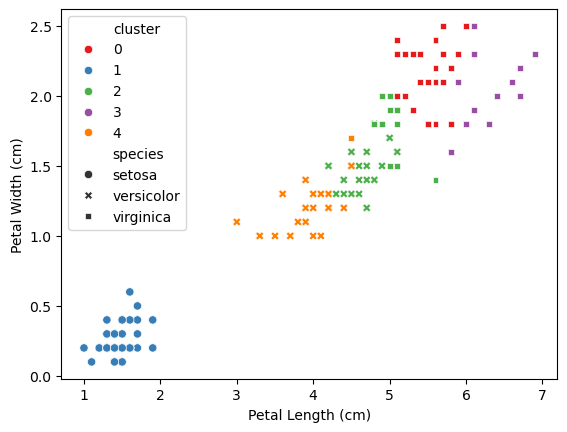

In [85]:
plot_compare_iris_n_clusters(5)

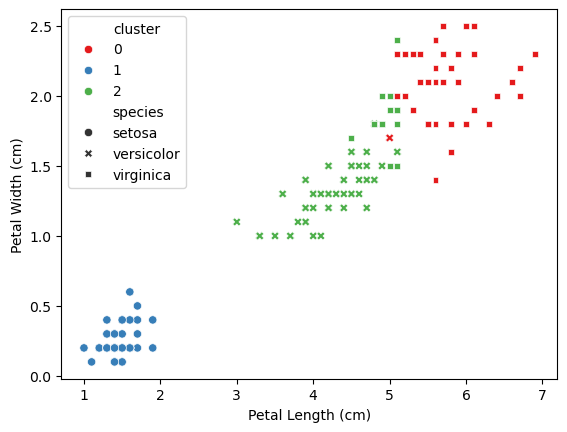

In [86]:
plot_compare_iris_n_clusters(3)

Vemos que el resultado se asemeja bastante. Podríamos calcular el rendimiento de la clusterización con respecto a las etiquetas reales como si de una clasificación se tratase.

Como sabemos que realmente existen 3 categorías, vamos a comparar los resultados obtenidos para 3 clusters. El número asignado a cada cluster no tiene por qué coincidir con el número asignado a cada clase real, así que para poder compararlos, vamos a asignar a cada cluster el número de clase real que más se repite en él.

In [87]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42).fit(iris.data)
df = pd.DataFrame({'cluster': kmeans.labels_, 'real_class': iris.target_names[iris.target]})
df

,cluster,real_class
0,1,setosa
1,1,setosa
2,1,setosa
3,1,setosa
4,1,setosa
...,...,...
145,0,virginica
146,2,virginica
147,0,virginica
148,0,virginica


Calculamos la moda de cada cluster y asignamos a cada cluster el número de clase real que más se repite en él.

In [88]:
modes = df.groupby('cluster')['real_class'].agg(pd.Series.mode)
modes

cluster
0     virginica
1        setosa
2    versicolor
Name: real_class, dtype: object

y añadimos la columna de la moda de cada cluster a nuestro DataFrame (asumiendo que hay una única moda clara en cada cluster). Habría que ser más refinado si hubiera empates, y sería problemática si dos clusters tuvieran la misma moda.

In [89]:
df['cluster_mode'] = df['cluster'].map(modes)
df

,cluster,real_class,cluster_mode
0,1,setosa,setosa
1,1,setosa,setosa
2,1,setosa,setosa
3,1,setosa,setosa
4,1,setosa,setosa
...,...,...,...
145,0,virginica,virginica
146,2,virginica,versicolor
147,0,virginica,virginica
148,0,virginica,virginica


Y ahora que el mismo número de cluster coincide con el mismo número de clase real, podemos compararlos.

In [91]:
from sklearn.metrics import classification_report

y_pred = KMeans(3, n_init = 20).fit_predict(iris.data)
print(classification_report(df.real_class, df.cluster_mode))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.77      0.94      0.85        50
   virginica       0.92      0.72      0.81        50

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150

